In [66]:
# Load the ECGs for the main project
import numpy as np
distdr_medians = np.load(r'\\amc.intra\data\group\diva\EP-research\Maarten Fleur\SafeHeart External Validation DL\ECG sets\DISTDR_medians_precprocessed.np.npy')

#Crop these as well, get the exterimities
# distdr_medians_cropped = distdr_medians[:, :6, 20:-20]
# distdr_medians_cropped.shape

#All leads
distdr_medians_cropped = distdr_medians[:, :, 20:-20]
distdr_medians_cropped.shape

(77099, 12, 210)

In [68]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# Define input layer
input_signal = Input(shape=(12, 210,))
latent_dim = 32

# Encoder layers
x = Flatten()(input_signal)
x = Dense(128, activation='relu', trainable=True)(x)
x = Dense(64, activation='relu', trainable=True)(x)

# Define mean and log-variance layers for latent variables
z_mean = Dense(latent_dim, trainable=True)(x)
z_log_var = Dense(latent_dim, trainable=True)(x)

# Define sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder layers
x = Dense(64, activation='relu', trainable=True)(z)
x = Dense(128, activation='relu', trainable=True)(x)
decoded = Dense(12 * 210, activation='sigmoid', trainable=True)(x)
decoded = Reshape((12, 210))(decoded)


vae_model = Model(input_signal, decoded)

vae_model.load_weights(r'C:\Users\mzkolk\Auto-encoder and time-varying features - Github\pretrained_autoencoder_weights_32.h5')

# Define VAE loss function
def vae_loss(input_signal, decoded):
    mse_loss = K.mean(K.square(input_signal - decoded), axis=(1,2))
    kl_loss = -0.00001 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return mse_loss + kl_loss

adam = Adam(learning_rate=0.0001)
vae_model.compile(optimizer=adam, loss=vae_loss)

# Define encoder model
encoder_model = Model(input_signal, z_mean)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=2,
                               verbose=1,
                               mode='min')

# Train the VAE model
history = vae_model.fit(distdr_medians_cropped, distdr_medians_cropped,
                        epochs=128,
                        batch_size=128,
                        shuffle=True,
                        validation_split=0.15,
                        callbacks=[early_stopping])

# Reconstruct input signal
reconstructed_signal = vae_model.predict(distdr_medians_cropped)

indices = np.random.choice(distdr_medians_cropped.shape[0], 77099, replace=False)
pearson_all = list()
for i, idx in enumerate(indices):
        for j in range(1, 6):
            correlation_matrix = np.corrcoef(distdr_medians_cropped[i, j], reconstructed_signal[i, j], rowvar=False)
            pearson_correlation = correlation_matrix[0, 1]
            pearson_all.append(pearson_correlation)
print("Pearson mean", np.mean(pearson_all))
print("Pearson std", np.std(pearson_all))

Train on 65534 samples, validate on 11565 samples
Epoch 1/128
65280/65534 [============================>.] - ETA: 0s - loss: 0.0073

C:\Users\mzkolk\Anaconda3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


65534/65534 [==============================] - 16s 250us/sample - loss: 0.0073 - val_loss: 0.0061
Epoch 2/128
65534/65534 [==============================] - 15s 231us/sample - loss: 0.0057 - val_loss: 0.0053
Epoch 3/128
65534/65534 [==============================] - 15s 228us/sample - loss: 0.0051 - val_loss: 0.0049
Epoch 4/128
65534/65534 [==============================] - 14s 219us/sample - loss: 0.0048 - val_loss: 0.0046
Epoch 5/128
65534/65534 [==============================] - 15s 234us/sample - loss: 0.0046 - val_loss: 0.0044
Epoch 6/128
65534/65534 [==============================] - 15s 223us/sample - loss: 0.0044 - val_loss: 0.0043
Epoch 7/128
65534/65534 [==============================] - 15s 232us/sample - loss: 0.0043 - val_loss: 0.0041
Epoch 8/128
65534/65534 [==============================] - 15s 235us/sample - loss: 0.0042 - val_loss: 0.0041
Epoch 9/128
65534/65534 [==============================] - 15s 221us/sample - loss: 0.0041 - val_loss: 0.0040
Epoch 10/128
65534/655

In [69]:
import pandas as pd
encoded_imgs = encoder_model.predict(distdr_medians_cropped)
encoded_imgs_df = pd.DataFrame(encoded_imgs)
encoded_imgs_df.to_csv(r'\\amc.intra\data\group\diva\EP-research\Maarten Fleur\ECG features_for_manuscript\COMBINED\latent_space_features_32.csv')
#encoded_imgs_df.to_csv(r'\\amc.intra\data\group\diva\EP-research\Maarten Fleur\ECG features_for_manuscript\COMBINED\latent_space_features.csv')

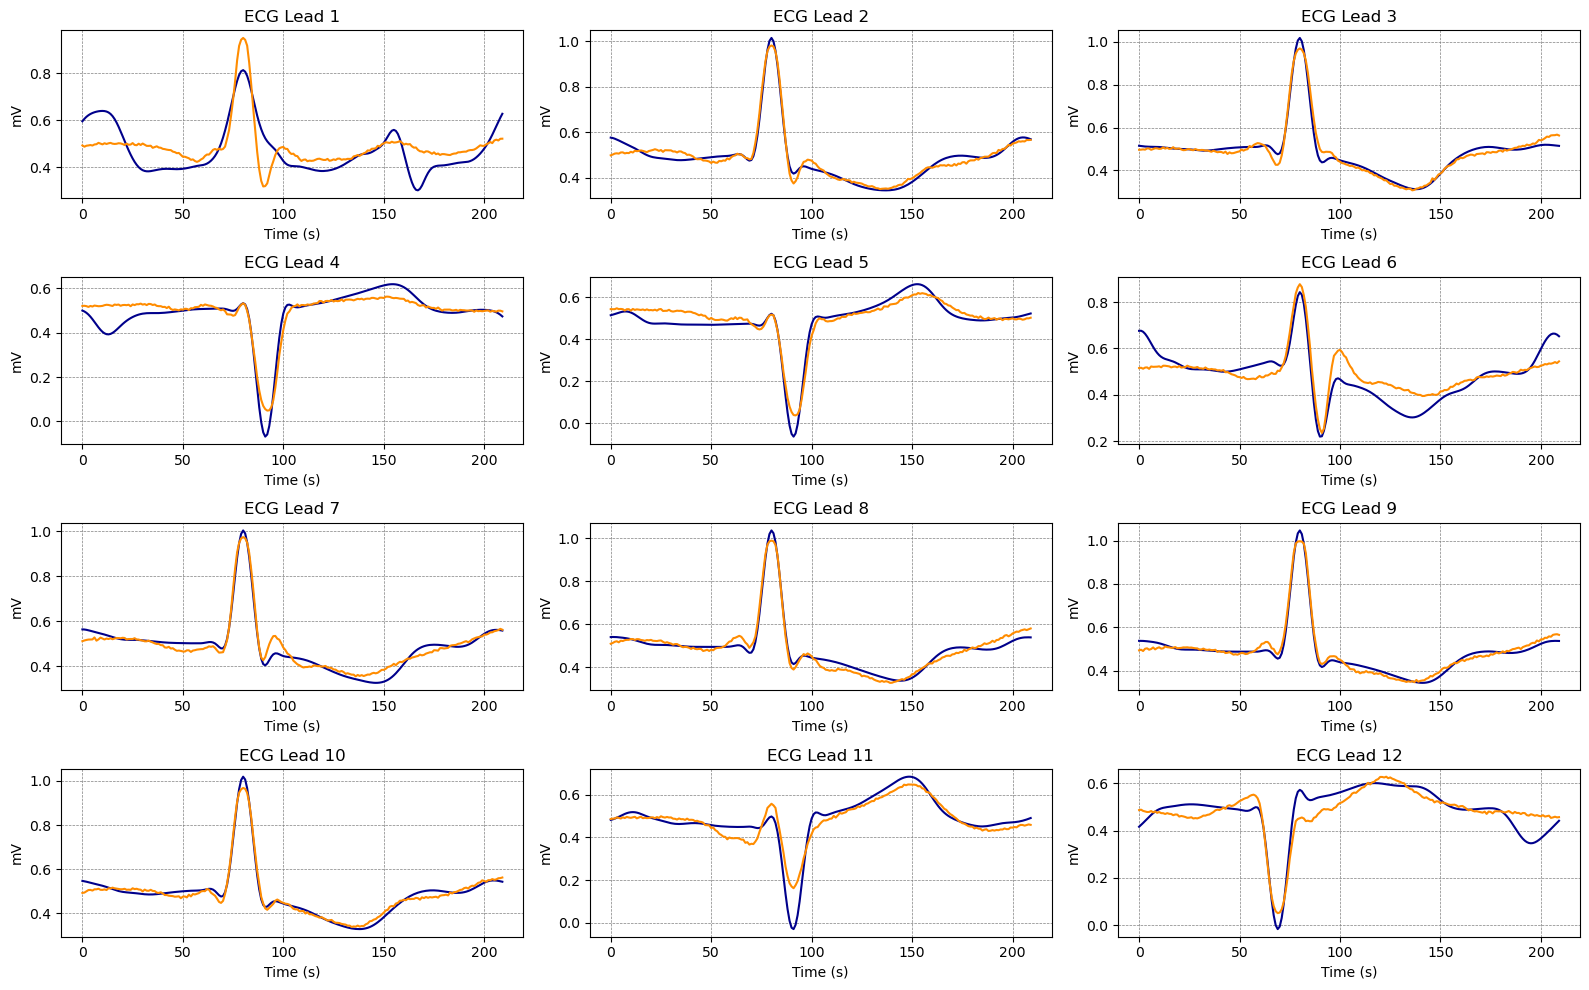

In [71]:
import numpy as np
import matplotlib.pyplot as plt

mean_signal = np.mean(reconstructed_signal, axis=0)

# assuming your ecgs array is called 'ecgs'
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 10))

# generate random case index
case_idx = np.random.randint(len(distdr_medians_cropped))

for i, ax in enumerate(axes.flatten()):
    ax.plot(distdr_medians_cropped[case_idx, i, :], linestyle='-', color='darkblue')
    ax.grid(linewidth=0.5, color='gray', linestyle='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('mV')
    ax.set_title(f'ECG Lead {i+1}')
    
    ax.plot(reconstructed_signal[case_idx, i, :], linestyle='-', color='darkorange')
    ax.grid(linewidth=0.5, color='gray', linestyle='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('mV')
    ax.set_title(f'ECG Lead {i+1}')  
    
plt.savefig(r"\\amc.intra\data\group\diva\EP-research\Maarten Fleur\Auto-encoder\Reconstructions\Reconstruction_1_32AE.tiff", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

In [76]:
df = pd.read_csv(r'\\amc.intra\data\group\diva\EP-research\Maarten Fleur\ECG features_for_manuscript\COMBINED\predictions_Ribeiro_06022023.csv', index_col=[0])
latent_space = pd.read_csv(r'\\amc.intra\data\group\diva\EP-research\Maarten Fleur\ECG features_for_manuscript\COMBINED\latent_space_features_32.csv', index_col=[0])


#Scaling data ECG
scaling_set = latent_space
features_mean = scaling_set.mean()
features_std = scaling_set.std()
scaling_set=((scaling_set-features_mean)/features_std)
latent_space = scaling_set


df['Unnamed: 0'] = df.index

#Predictions above 0.8 counts as 'yes'
print(df.shape)
print(log.shape)

#Merge it
ecg_both_sets = pd.concat([df, ECG_clin], axis=1)
ecg_both_sets = pd.concat([ecg_both_sets, latent_space], axis=1)

ecg_both_sets.shape
ecg_both_sets.drop(columns=['Unnamed: 0', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0_x'], inplace=True)

df = ecg_both_sets[['Ventricular Heart Rate', 'Atrial Heart Rate', 'PR Interval', 'QRS Duration', 'QT Interval', 
                    'RR Interval', 'QTc Interval', 'QTc Bazett', 'P Axis', 'R Axis', 'T Axis', '1st degree AV block',
                    'RBBB', 'LBBB', 'SB', 'AF', 'ST']]

ecg_both_sets.to_csv(r'\\amc.intra\data\group\diva\EP-research\Maarten Fleur\ECG features_for_manuscript\COMBINED\ecg_timevarying_latent_32.csv')

(77099, 7)
(77099, 39)


# Traverse

C:\Users\mzkolk\AppData\Local\Temp\ipykernel_13348\698704607.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  traverse_range = np.array([(perc_5), (perc_25), factor, (perc_75), (perc_95)])


<Figure size 640x480 with 0 Axes>

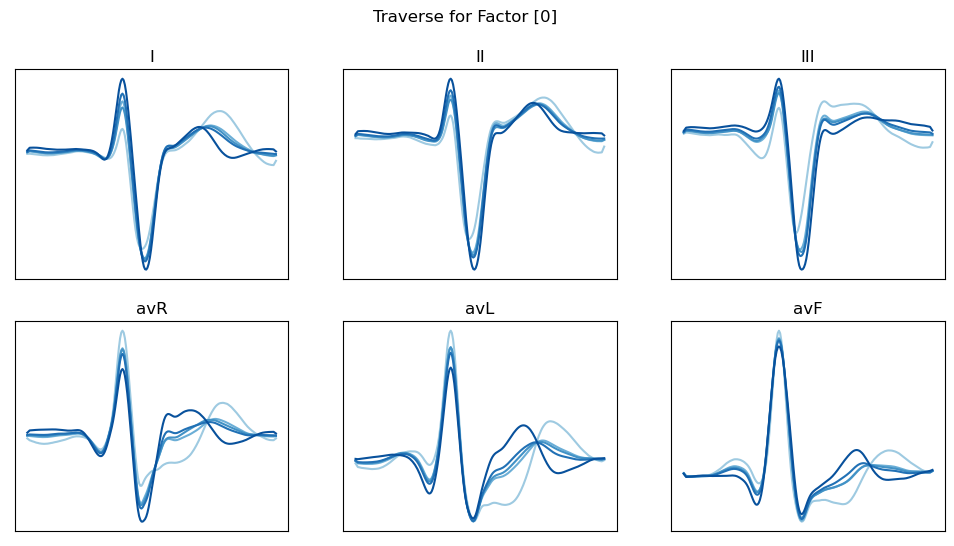

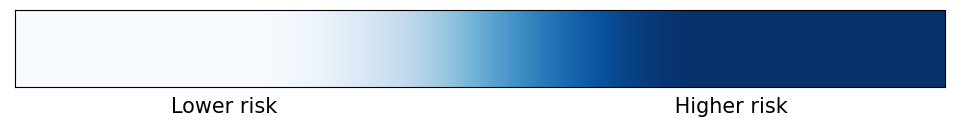

In [57]:
#Decoder
# Define decoder model
decoder_input = Input(shape=(latent_dim,))
decoded_layer1 = vae_model.layers[-4](decoder_input)
decoded_layer2 = vae_model.layers[-3](decoded_layer1)
decoded_layer3 = vae_model.layers[-2](decoded_layer2)
decoded_layer4 = vae_model.layers[-1](decoded_layer3)
decoder_output = Reshape((6, 210))(decoded_layer4)
decoder_model = Model(decoder_input, decoder_output)

import numpy as np
import matplotlib.pyplot as plt

titles = ['I', 'II', 'III', 'avR', 'avL', 'avF']

# Define function to plot the traverse for a specific factor
def plot_traverse(reconstructed_signals):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
    fig.suptitle(title)
    #colors = ['#08306b', '#08519c', '#2171b5', '#4292c6', '#6baed6', '#9ecae1']
    colors = ['#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c']
 #   colors = ['#c2d4dd', '#a1b9c4', '#819eac', '#617493', '#415979']

    for i, ax in enumerate(axes.flatten()[::-1]):
        # Subtract the mean value of each signal
        baseline1 = np.mean(reconstructed_signals[0][:, i, :])
        baseline2 = np.mean(reconstructed_signals[1][:, i, :])
        baseline3 = np.mean(reconstructed_signals[2][:, i, :])
        baseline4 = np.mean(reconstructed_signals[3][:, i, :])
        baseline5 = np.mean(reconstructed_signals[4][:, i, :])

        smoothed1 = np.convolve(np.median(reconstructed_signals[0][:, i, :]-baseline1, axis=0), np.ones(5)/5, mode='same')
        smoothed2 = np.convolve(np.median(reconstructed_signals[1][:, i, :]-baseline2, axis=0), np.ones(5)/5, mode='same')
        smoothed3 = np.convolve(np.median(reconstructed_signals[2][:, i, :]-baseline3, axis=0), np.ones(5)/5, mode='same')
        smoothed4 = np.convolve(np.median(reconstructed_signals[3][:, i, :]-baseline4, axis=0), np.ones(5)/5, mode='same')
        smoothed5 = np.convolve(np.median(reconstructed_signals[4][:, i, :]-baseline5, axis=0), np.ones(5)/5, mode='same')

        ax.plot(smoothed1, linestyle='-', color=colors[0])
        ax.plot(smoothed2, linestyle='-', color=colors[1])
        ax.plot(smoothed3, linestyle='-', color=colors[2])
        ax.plot(smoothed4, linestyle='-', color=colors[3])
        ax.plot(smoothed5, linestyle='-', color=colors[4])

        ax.grid(linewidth=1, color='gray', linestyle='--')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[-(i+1)])

    # Create the color bar plot
    fig2, ax2 = plt.subplots(figsize=(12, 1))
    cmap = plt.cm.get_cmap('Blues')
    values = np.linspace(0, 1, num=100)
    X, Y = np.meshgrid([0, 1], values)
    im = ax2.imshow(X, cmap=cmap, aspect='auto', origin='lower')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xlabel('Lower risk                                                            Higher risk', fontsize=15)

    # Create and adjust the color bar
#     #cbar = plt.colorbar(im, ax=ax2, orientation='horizontal', pad=0.1)
#     cbar.set_ticks([])
#     cbar.ax.tick_params(labelsize=10, length=0, pad=8)    plt.tight_layout()   
 
    plt.show()
    plt.close()


factor_number = [0]

# Loop through all factors and plot the traverses
for i in factor_number:
    # Select the specific factor
    factor = encoded_imgs[:, factor_number]
    perc_5 = np.percentile(factor, 5)
    perc_25 = np.percentile(factor, 40)
    perc_75 = np.percentile(factor, 60)
    perc_95 = np.percentile(factor, 95)

    # Define the range of values for the factor traverse
    traverse_range = np.array([(perc_5), (perc_25), factor, (perc_75), (perc_95)])
    # Initialize an array to store the reconstructed signals
    reconstructed_signals = np.zeros((len(traverse_range), encoded_imgs.shape[0], 6, 210))

    # Traverse the factor and reconstruct the signals
    for i, traverse_value in enumerate(traverse_range):
        # Create a copy of the factor array
        factor_traverse = factor.copy()
        # Set the value of the factor to the traverse value
        factor_traverse = traverse_value
        # Replace the factor in the encoded space with the new traverse values
        encoded_traverse = encoded_imgs.copy()
        encoded_traverse[:, factor_number] = factor_traverse
        # Reconstruct the signals using the decoder model
        reconstructed_traverse = decoder_model.predict(encoded_traverse)
        # Append the reconstructed signals to the array
        reconstructed_signals[i] = reconstructed_traverse

    # Plot the traverse for this factor
    title = f'Traverse for Factor {factor_number}'
    plt.savefig(r"\\amc.intra\data\group\diva\EP-research\Maarten Fleur\Auto-encoder\Traverse\Factor12.tiff", dpi=400, bbox_inches='tight')

    plot_traverse(reconstructed_signals)


C:\Users\mzkolk\AppData\Local\Temp\ipykernel_13348\536119777.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  traverse_range = np.array([(perc_5), (perc_25), factor, (perc_75), (perc_95)])
C:\Users\mzkolk\Anaconda3\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


<Figure size 640x480 with 0 Axes>

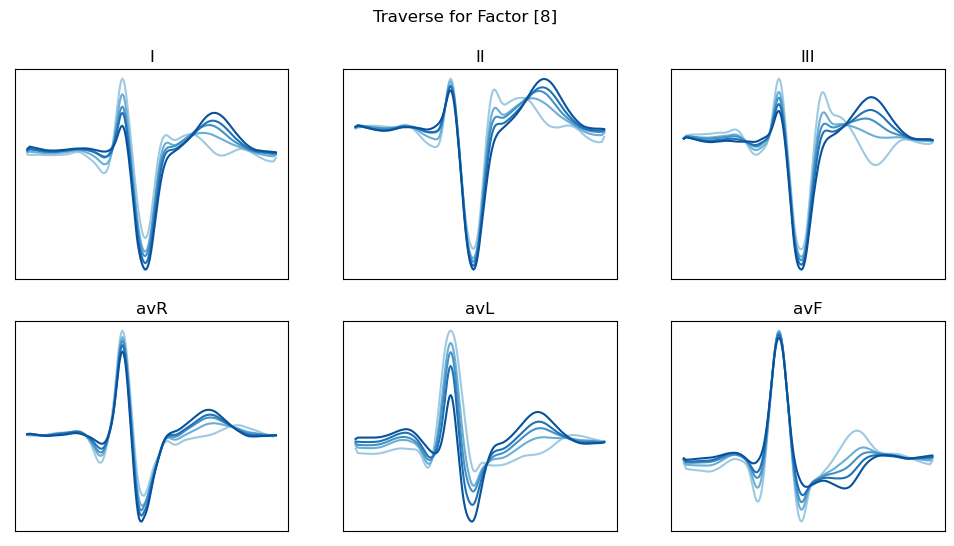

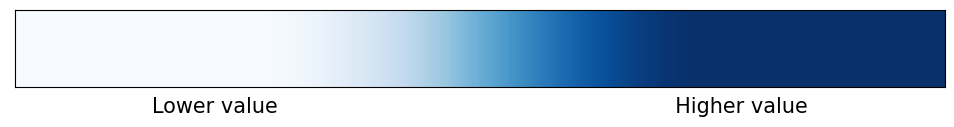

In [65]:
#Decoder
# Define decoder model
decoder_input = Input(shape=(latent_dim,))
decoded_layer1 = vae_model.layers[-4](decoder_input)
decoded_layer2 = vae_model.layers[-3](decoded_layer1)
decoded_layer3 = vae_model.layers[-2](decoded_layer2)
decoded_layer4 = vae_model.layers[-1](decoded_layer3)
decoder_output = Reshape((6, 210))(decoded_layer4)
decoder_model = Model(decoder_input, decoder_output)

import numpy as np
import matplotlib.pyplot as plt

titles = ['I', 'II', 'III', 'avR', 'avL', 'avF']

# Define function to plot the traverse for a specific factor
def plot_traverse(reconstructed_signals):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
    fig.suptitle(title)
    #colors = ['#08306b', '#08519c', '#2171b5', '#4292c6', '#6baed6', '#9ecae1']
    colors = ['#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c']
 #   colors = ['#c2d4dd', '#a1b9c4', '#819eac', '#617493', '#415979']

    for i, ax in enumerate(axes.flatten()[::-1]):
        # Subtract the mean value of each signal
        baseline1 = np.mean(reconstructed_signals[0][:, i, :])
        baseline2 = np.mean(reconstructed_signals[1][:, i, :])
        baseline3 = np.mean(reconstructed_signals[2][:, i, :])
        baseline4 = np.mean(reconstructed_signals[3][:, i, :])
        baseline5 = np.mean(reconstructed_signals[4][:, i, :])

        smoothed1 = np.convolve(np.median(reconstructed_signals[0][:, i, :]-baseline1, axis=0), np.ones(5)/5, mode='same')
        smoothed2 = np.convolve(np.median(reconstructed_signals[1][:, i, :]-baseline2, axis=0), np.ones(5)/5, mode='same')
        smoothed3 = np.convolve(np.median(reconstructed_signals[2][:, i, :]-baseline3, axis=0), np.ones(5)/5, mode='same')
        smoothed4 = np.convolve(np.median(reconstructed_signals[3][:, i, :]-baseline4, axis=0), np.ones(5)/5, mode='same')
        smoothed5 = np.convolve(np.median(reconstructed_signals[4][:, i, :]-baseline5, axis=0), np.ones(5)/5, mode='same')

        ax.plot(smoothed1, linestyle='-', color=colors[0])
        ax.plot(smoothed2, linestyle='-', color=colors[1])
        ax.plot(smoothed3, linestyle='-', color=colors[2])
        ax.plot(smoothed4, linestyle='-', color=colors[3])
        ax.plot(smoothed5, linestyle='-', color=colors[4])

        ax.grid(linewidth=1, color='gray', linestyle='--')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[-(i+1)])

    # Create the color bar plot
    fig2, ax2 = plt.subplots(figsize=(12, 1))
    cmap = plt.cm.get_cmap('Blues')
    values = np.linspace(0, 1, num=100)
    X, Y = np.meshgrid([0, 1], values)
    im = ax2.imshow(X, cmap=cmap, aspect='auto', origin='lower')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xlabel('Lower value                                                            Higher value', fontsize=15)
 
    plt.show()
    plt.close()


factor_number = [8]

# Loop through all factors and plot the traverses
for i in factor_number:
    # Select the specific factor
    factor = encoded_imgs[:, factor_number]
    perc_5 = np.percentile(factor, 5)
    perc_25 = np.percentile(factor, 25)
    perc_75 = np.percentile(factor, 75)
    perc_95 = np.percentile(factor, 95)

    # Define the range of values for the factor traverse
    traverse_range = np.array([(perc_5), (perc_25), factor, (perc_75), (perc_95)])
    # Initialize an array to store the reconstructed signals
    reconstructed_signals = np.zeros((len(traverse_range), encoded_imgs.shape[0], 6, 210))

    # Traverse the factor and reconstruct the signals
    for i, traverse_value in enumerate(traverse_range):
        # Create a copy of the factor array
        factor_traverse = factor.copy()
        # Set the value of the factor to the traverse value
        factor_traverse = traverse_value
        # Replace the factor in the encoded space with the new traverse values
        encoded_traverse = encoded_imgs.copy()
        encoded_traverse[:, factor_number] = factor_traverse
        # Reconstruct the signals using the decoder model
        reconstructed_traverse = decoder_model.predict(encoded_traverse)
        # Append the reconstructed signals to the array
        reconstructed_signals[i] = reconstructed_traverse

    # Plot the traverse for this factor
    title = f'Traverse for Factor {factor_number}'
    plt.savefig(r"\\amc.intra\data\group\diva\EP-research\Maarten Fleur\Auto-encoder\Traverse\Factor12.tiff", dpi=400, bbox_inches='tight')

plot_traverse(reconstructed_signals)


# Corrplot

C:\Users\mzkolk\AppData\Local\Temp\ipykernel_13348\1007088849.py:1: DtypeWarning: Columns (7,12,33,34,38,40,44,97) have mixed types. Specify dtype option on import or set low_memory=False.
  ecg = pd.read_csv(r'\\amc.intra\data\group\diva\EP-research\Maarten Fleur\ECG features_for_manuscript\COMBINED\ecg_timevarying_latent.csv')


<Figure size 1200x1200 with 0 Axes>

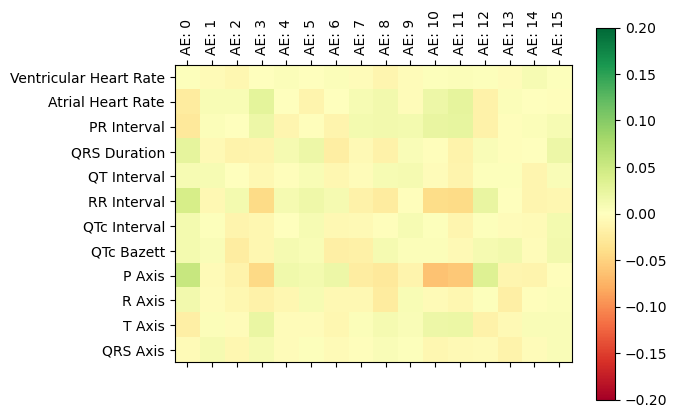

In [64]:
ecg = pd.read_csv(r'\\amc.intra\data\group\diva\EP-research\Maarten Fleur\ECG features_for_manuscript\COMBINED\ecg_timevarying_latent.csv')

latent_space = ecg[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']]
df = ecg[['1st degree AV block', 'RBBB', 'LBBB', 'SB', 'AF', 'ST']]

df = df.rename(columns = {'RBBB': 'Right bundle branch block',
              'LBBB' : 'Left bundle branch block',
              'ST' : 'Sinus tachycardia',
              'SB' : 'Sinus bradycardia',
               'AF' :  'Atrial fibrillation'})

df = ecg[['Ventricular Heart Rate', 'Atrial Heart Rate', 'PR Interval', 'QRS Duration', 
          'QT Interval', 'RR Interval', 'QTc Interval', 'QTc Bazett', 'P Axis', 'R Axis', 
          'T Axis', 'QRS Axis']]
column_names = {}

for col in latent_space.columns:
    if col.isnumeric():
        column_names[col] = 'AE: {}'.format(col)
latent_space = latent_space.rename(columns=column_names)

corr_matrix = pd.concat([df, latent_space], axis=1, keys=['df', 'latent_space']).corr().loc['df', 'latent_space']

# plot the sorted correlation matrix
fig = plt.figure(figsize=(12, 12)) # set the figure size to 10x10
plt.matshow(corr_matrix, cmap="RdYlGn")
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=10, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index, fontsize=10)
plt.colorbar()
plt.clim(-0.2, 0.2) # set the colorbar limit to go from 0 to 1
#plt.savefig(r"\\amc.intra\data\group\diva\EP-research\Maarten Fleur\Auto-encoder\Correlation matrix\Correlation matrix.tiff", dpi=300, bbox_inches='tight')
plt.show()

In [63]:
df

,Ventricular Heart Rate,Atrial Heart Rate,PR Interval,QRS Duration,QT Interval,RR Interval,QTc Interval,QTc Bazett,P Axis,R Axis,T Axis,QRS Axis
0,72,72.0,132.0,90.0,404.0,828.0,442.0,442.0,50.0,33.0,163.0,NaN
1,73,73.0,152.0,100.0,406.0,812.0,447.0,449.0,62.0,44.0,150.0,NaN
2,71,71.0,150.0,96.0,416.0,NaN,452.0,NaN,47.0,38.0,146.0,NaN
3,68,68.0,138.0,98.0,430.0,NaN,457.0,NaN,62.0,44.0,142.0,NaN
4,71,71.0,142.0,98.0,372.0,838.0,404.0,404.0,55.0,50.0,169.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
77094,83,NaN,192.0,102.0,400.0,NaN,470.0,NaN,69.0,NaN,68.0,95.0
77095,70,NaN,196.0,98.0,392.0,NaN,423.0,NaN,52.0,NaN,83.0,64.0
77096,65,NaN,204.0,98.0,400.0,NaN,416.0,NaN,47.0,NaN,71.0,48.0
77097,74,NaN,192.0,98.0,380.0,NaN,422.0,NaN,53.0,NaN,77.0,72.0
